### Scalar Classifier 

As first test, train a classifier without input. 

In [1]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt


Data distribution over $\theta$ to sample from. 

In [2]:
dist = torch.distributions.Normal(10, 5)
thetas = torch.arange(-10, 30, 0.01)

Define a loss

In [3]:
def StepLoss_weighted(weights, threshold):

    assert len(weights) == 2

    def loss(theta, decision):
        """custom loss function (BCE with class weights)

        Args:
            theta (torch.Tensor): observed/true parameter value
            decision (int): indicates decision: 0 (below threshold) or  1(above treshold)
            threshold (float, optional): threshold for binarized decisons, defaults to 5.0.

        Returns:
            float: incurred loss
        """
        #assert decision in [0,1], "decision has to be one of 0 (below threshold) or  1(above treshold)"
        return decision * (1 - torch.gt(theta,threshold).type(torch.float)) * weights[0]  + \
            (1-decision) * torch.gt(theta,threshold).type(torch.float) * weights[1] 
    
    return loss

In [4]:
threshold = 5.0
loss = StepLoss_weighted(weights = [5., 1.], threshold=threshold)

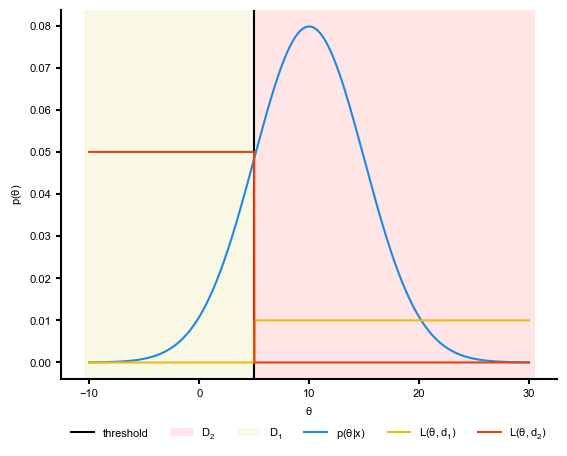

In [5]:
probs = dist.log_prob(thetas).exp()


with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    plt.axvline(x=5.0, color='k', label='threshold')
    plt.axvspan(5, 30.5, facecolor='r', alpha=0.1, label=r'$D_2$')
    plt.axvspan(-10.5, 5, facecolor='y', alpha=0.1, label=r'$D_1$')

    plt.plot(thetas, probs, color='#1E88E5', label=r'$p(\theta|x)$')

    plt.plot(thetas, 0.01*loss(thetas, 0), color='#EFB913', label=r'$L(\theta, d_1)$')
    plt.plot(thetas, 0.01*loss(thetas, 1), color='#EC400E', label=r'$L(\theta, d_2)$')
    
    #plt.xticks([]); plt.yticks([])
    plt.xlabel(r'$\theta$'); plt.ylabel(r'$p(\theta)$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=6)
          
    #plt.savefig('figures/setup.pdf')
    plt.show()

In [6]:
N= 5000
th_train = dist.sample((N,))
y_train = (th_train>threshold).float()*2-1  #labels ±1

In [7]:
# classifier expected to converge to
loss(th_train, 0).sum() / (loss(th_train, 0) + loss(th_train, 1)).sum()

tensor(0.5205)

Define a simple classifier (only a single scalar value).

In [8]:
c = torch.nn.Parameter(torch.tensor([0.3]),requires_grad=True)

Train classifier

In [9]:
optimizer = torch.optim.SGD([c], lr=0.00001)

loss_values = []
for epoch in range(2000):
    optimizer.zero_grad()
    loss_value = -(c.log() * loss(th_train, 0).sum() + (torch.ones_like(c)-c).log() * loss(th_train,1).sum())
    loss_values.append(loss_value)
    loss_value.backward()
    optimizer.step()
    if epoch%100==0:
        print(f"{epoch}\t c = {c.item():.8f}\t L = {loss_value.item():.8f}", end='\r')

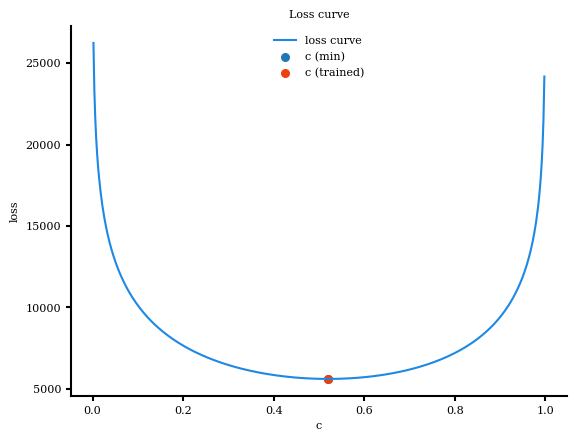

In [10]:
c_ls = torch.linspace(0, 1, 500)
result = -(torch.log(c_ls) * loss(th_train, 0).sum() + torch.log(1-c_ls) * loss(th_train, 1).sum())

with mpl.rc_context(fname="loss_calibration/.matplotlibrc"):
    plt.title('Loss curve')
    plt.plot(c_ls.numpy(), result.numpy(), color='#1E88E5', label='loss curve')
    plt.xlabel('c'); plt.ylabel('loss')
    plt.scatter(c_ls[torch.argmin(result)].numpy(), torch.min(result).numpy(), s=30,label='c (min)')
    plt.scatter(c.detach().numpy(), -(torch.log(c.detach()) * loss(th_train, 0).sum() + torch.log(1-c.detach()) * loss(th_train, 1).sum()).numpy(), color='#EC400E', s=30, label='c (trained)')
    plt.legend()
    #plt.savefig('figures/loss_curve.pdf')



In [14]:
# check whether it converges to ratio of expected loss under prior
torch.isclose(loss(th_train, 0).sum() / (loss(th_train, 0) + loss(th_train, 1)).sum(), c).item()

True

#### Test Integration
Understand what the classifier converges to

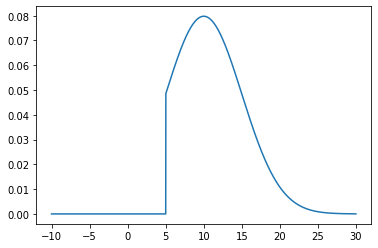

In [ ]:
def loss_predict_smaller(th):
    return dist.log_prob(torch.as_tensor(th)).exp()*loss(th,0)
plt.plot(thetas, loss_predict_smaller(thetas))
i1 = loss_predict_smaller(thetas).sum()

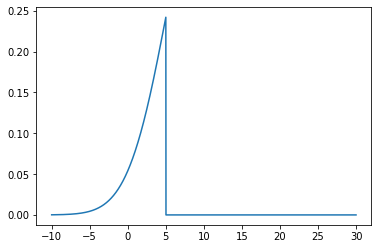

In [ ]:
def loss_predict_larger(th):
    return dist.log_prob(torch.as_tensor(th)).exp()*loss(th,1)
plt.plot(thetas, loss_predict_larger(thetas))
i2 = loss_predict_larger(thetas).sum()

In [ ]:
i1/(i1+i2)

tensor(0.5143)